<a href="https://colab.research.google.com/github/bandido007/Conformal-Prediction-projects/blob/main/Regularized_Adaptive_Conformal_Prediction_for_Diabetes_Risk_Assessment_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
!pip -q install catboost
from catboost import CatBoostClassifier

from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

!pip -q install tabulate
from tabulate import tabulate

# ***Conformal Prediction***
here is the implementation of the Regularized Adaptive Prediction Set
-

In [15]:
class EnhancedRAPSMedical:

    """
    Enhanced Regularized Adaptive Prediction Sets (RAPS) implementation for medical diagnostics.
    Implements conformal prediction with additional medical-specific enhancements.
    """
    def __init__(self, base_model, confidence_threshold=0.9, uncertainty_threshold=0.65):

        """
        Initialize the RAPS model with medical-specific thresholds.

        Args:
            base_model: Any sklearn-compatible classifier with predict_proba method
            confidence_threshold (float): Threshold for high-confidence predictions
            uncertainty_threshold (float): Threshold for uncertain predictions
        """

        self.base_model = base_model
        self.confidence_threshold = confidence_threshold
        self.uncertainty_threshold = uncertainty_threshold
        self.conformal_metrics = ConformalMetrics()
        self.calibration_scores = None
        self.calibration_threshold = None

    def predict_with_confidence(self, X):
        """
        Make predictions with confidence assessment.
        Provides both predictions and uncertainty quantification.

        Args:
            X (np.array): Input features

        Returns:
            tuple: (prediction_set, confidence_score, assessment_label)
        """
        if not hasattr(self.base_model, 'predict_proba'):
            raise AttributeError("Base model must support predict_proba")

        # Get probability predictions
        probs = self.base_model.predict_proba(X.reshape(1, -1))
        sorted_probs = np.sort(probs[0])[::-1]
        max_prob = sorted_probs[0]
        ordered_classes = np.argsort(probs[0])[::-1]

        # Map numeric classes to interpretable labels
        class_labels = {0: "Non-Diabetic", 1: "Diabetic"}

        # Map numeric classes to interpretable labels
        if max_prob >= self.confidence_threshold:
            prediction_set = [class_labels[ordered_classes[0]]]
            assessment = "Definitive"
        elif max_prob < self.uncertainty_threshold:
            prediction_set = [class_labels[c] for c in ordered_classes[:2]]
            assessment = "Highly Uncertain"
        else:
            prediction_set = [class_labels[ordered_classes[0]]]
            if sorted_probs[1] > self.uncertainty_threshold / 2:
                prediction_set.append(class_labels[ordered_classes[1]])
            assessment = "Uncertain"

        return prediction_set, max_prob, assessment

    def calibrate(self, X_cal, y_cal, alpha=0.1):
        """Calibrate the model using conformal prediction."""
        scores = self.compute_nonconformity_scores(X_cal, y_cal)
        self.calibration_scores = scores
        self.calibration_threshold = np.quantile(scores, 1 - alpha)

    def compute_nonconformity_scores(self, X, y_true):
        """Compute nonconformity scores."""
        probs = self.base_model.predict_proba(X)
        scores = 1 - probs[np.arange(len(y_true)), y_true]
        return scores

    def regularized_conformal_prediction(self, X_train, y_train, X_cal, y_cal,
                                       X_test, y_test, alpha=0.1, reg_param=0.01,
                                       n_trials=1000, randomized=True):
        """
        Implement regularized adaptive conformal prediction with multiple trials.

        Args:
            X_train, y_train: Training data
            X_cal, y_cal: Calibration data
            X_test, y_test: Test data
            alpha (float): Target miscoverage rate (default: 0.1)
            reg_param (float): Regularization parameter (default: 0.01)
            n_trials (int): Number of random trials (default: 1000)
            randomized (bool): Whether to use randomization (default: True)

        Returns:
            dict: Comprehensive results including coverages, set sizes, and metrics
        """

        results = {
            'coverages': [],
            'set_sizes': [],
            'thresholds': [],
            'prediction_sets': [],
            'metrics': {}
        }

        for _ in range(n_trials):

            # Train base model
            self.base_model.fit(X_train, y_train)

            # Get probability predictions
            cal_probs = self.base_model.predict_proba(X_cal)
            test_probs = self.base_model.predict_proba(X_test)

            # Apply regularization
            n_classes = cal_probs.shape[1]
            reg_vec = reg_param * np.exp(-np.arange(n_classes))

            # Sort probabilities and apply regularization
            cal_pi = cal_probs.argsort(1)[:,::-1]
            cal_srt = np.take_along_axis(cal_probs, cal_pi, axis=1)
            cal_srt_reg = cal_srt + reg_vec

            # Calculate conformity scores
            n_cal = len(y_cal)
            cal_L = np.where(cal_pi == y_cal.values[:, None])[1]

            # Add randomization if enabled
            if randomized:
                rand_terms = np.random.rand(n_cal) * cal_srt_reg[np.arange(n_cal), cal_L]
            else:
                rand_terms = 0


            # Calculate calibration scores and threshold
            cal_scores = cal_srt_reg.cumsum(axis=1)[np.arange(n_cal), cal_L] - rand_terms
            threshold = np.quantile(cal_scores,
                                  np.ceil((n_cal+1)*(1-alpha))/n_cal,
                                  method='higher')

            # Generate prediction sets for test data
            n_test = len(y_test)
            test_pi = test_probs.argsort(1)[:,::-1]
            test_srt = np.take_along_axis(test_probs, test_pi, axis=1)
            test_srt_reg = test_srt + reg_vec
            test_cumsum = test_srt_reg.cumsum(axis=1)


            # Apply randomization to test predictions
            if randomized:
                indicators = (test_cumsum - np.random.rand(n_test, 1) * test_srt_reg) <= threshold
            else:
                indicators = test_cumsum - test_srt_reg <= threshold

            # Ensure at least one prediction per set
            indicators[:, 0] = True
            pred_sets = np.take_along_axis(indicators, test_pi.argsort(axis=1), axis=1)

            # Calculate and store metrics
            results['coverages'].append(self.conformal_metrics.average_coverage(pred_sets, y_test))
            results['set_sizes'].append(self.conformal_metrics.average_set_size(pred_sets))
            results['thresholds'].append(threshold)
            results['prediction_sets'].append(pred_sets)

        # Calculate final prediction sets and metrics
        final_pred_sets = np.stack(results['prediction_sets']).mean(axis=0) > 0.5

        # Store comprehensive metrics
        results['metrics'] = {
            'average_coverage': np.mean(results['coverages']),
            'average_set_size': np.mean(results['set_sizes']),
            'error_rate': self.conformal_metrics.error_rate(final_pred_sets, y_test),
            'efficiency': self.conformal_metrics.efficiency(final_pred_sets)
        }


        # Add age-stratified coverage if available
        if isinstance(X_test, pd.DataFrame) and 'age' in X_test.columns:
            age_groups = pd.qcut(X_test['age'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
            results['metrics']['age_stratified_coverage'] = \
                self.conformal_metrics.stratified_coverage(final_pred_sets, y_test, age_groups)

        return results

In [16]:
class ConformalMetrics:
    """
    A class for calculating various metrics for conformal prediction evaluation.
    This class provides methods to assess the quality and reliability of conformal prediction sets.
    """

    def average_coverage(self, pred_sets, y_true):
        """
        Calculate the average coverage of the prediction sets.

        Args:
            pred_sets: numpy array of prediction sets (binary indicators)
            y_true: true labels (numpy array or pandas series)
        """

        if isinstance(y_true, pd.Series):
            y_true = y_true.values

        # Convert prediction sets to binary indicators if not already
        if isinstance(pred_sets, list):
            pred_sets = np.array(pred_sets)

        # Calculate coverage for binary classification
        correct = pred_sets[np.arange(len(y_true)), y_true]
        return np.mean(correct)

    def average_set_size(self, pred_sets):
        """
        Calculate the average size of prediction sets.
        Smaller set sizes indicate more precise predictions.

        Args:
            pred_sets (np.array/list): Prediction sets

        Returns:
            float: Average number of predictions per set
        """
        if isinstance(pred_sets, list):
            pred_sets = np.array(pred_sets)
        return np.mean(np.sum(pred_sets, axis=1))

    def error_rate(self, pred_sets, y_true):
        """
        Calculate the error rate (complement of coverage).

        Args:
            pred_sets (np.array): Prediction sets
            y_true (np.array): True labels

        Returns:
            float: Proportion of incorrect predictions
        """
        return 1 - self.average_coverage(pred_sets, y_true)

    def efficiency(self, pred_sets):
        """Calculate efficiency (mean set size)."""
        return self.average_set_size(pred_sets)

    def stratified_coverage(self, pred_sets, y_true, stratification):
        """
        Calculate coverage separately for different groups/strata.
        Useful for assessing fairness and bias across different subgroups.

        Args:
            pred_sets (np.array): Prediction sets
            y_true (np.array): True labels
            stratification (np.array): Group labels for stratification

        Returns:
            dict: Coverage for each stratum
        """

        if isinstance(y_true, pd.Series):
            y_true = y_true.values
        if isinstance(stratification, pd.Series):
            stratification = stratification.values

        results = {}
        for group in np.unique(stratification):
            mask = stratification == group
            coverage = self.average_coverage(pred_sets[mask], y_true[mask])
            results[group] = coverage
        return results

    def conditional_coverage(self, pred_sets, y_true, conditions):
        """Calculate conditional coverage for specific conditions."""
        if isinstance(y_true, pd.Series):
            y_true = y_true.values
        if isinstance(conditions, pd.Series):
            conditions = conditions.values

        results = {}
        for condition in np.unique(conditions):
            mask = conditions == condition
            coverage = self.average_coverage(pred_sets[mask], y_true[mask])
            results[condition] = coverage
        return results

In [17]:
class EnhancedPimaDiabetesAnalyzer:
    def __init__(self, data_path):
        self.data_path = data_path
        self.scaler = StandardScaler()
        self.models = {}
        self.stacking_model = None
        self.feature_names = None

    def _get_assessment(self, confidence):
        """
        Determine assessment level based on confidence score.

        Args:
            confidence (float): Confidence score between 0 and 1

        Returns:
            str: Assessment level description
        """
        if confidence >= 0.90:
            return "Definitive prediction with high confidence"
        elif confidence >= 0.70:
            return "Uncertain prediction with moderate confidence"
        else:
            return "Highly uncertain prediction with low confidence"

    def plot_comprehensive_analysis(self, all_results, y_test):
        """Enhanced visualization with integrated metrics plotting."""
        fig = plt.figure(figsize=(20, 20))
        gs = fig.add_gridspec(4, 2)

        ax1 = fig.add_subplot(gs[0, 0])
        for model_name, results in all_results.items():
            sns.kdeplot(results['coverages'], label=model_name, ax=ax1)
        ax1.axvline(0.9, color='red', linestyle='--', label='Target (1-α)')
        ax1.set_title('Coverage Distribution Across Trials')
        ax1.set_xlabel('Coverage')
        ax1.legend()

        ax2 = fig.add_subplot(gs[0, 1])
        for model_name, results in all_results.items():
            sns.kdeplot(results['set_sizes'], label=model_name, ax=ax2)
        ax2.set_title('Set Size Distribution')
        ax2.set_xlabel('Average Set Size')
        ax2.legend()

        ax3 = fig.add_subplot(gs[1, 0])
        for model_name, results in all_results.items():
            ax3.scatter(results['set_sizes'], results['coverages'],
                       alpha=0.5, label=model_name)
        ax3.set_xlabel('Average Set Size')
        ax3.set_ylabel('Coverage')
        ax3.set_title('Coverage vs Set Size Trade-off')
        ax3.legend()

        ax4 = fig.add_subplot(gs[1, 1])
        class_coverage_data = []
        for model_name, results in all_results.items():
            metrics = results['metrics']
            for i, cov in enumerate([metrics['average_coverage']]):
                class_coverage_data.append({
                    'Model': model_name,
                    'Class': f'Class {i}',
                    'Coverage': cov
                })
        df_class_cov = pd.DataFrame(class_coverage_data)
        sns.boxplot(data=df_class_cov, x='Class', y='Coverage', hue='Model', ax=ax4)
        ax4.set_title('Class-conditional Coverage')

        ax5 = fig.add_subplot(gs[2, 0])
        for model_name, results in all_results.items():
            ax5.plot(results['coverages'], label=model_name)
        ax5.set_title('Coverage over Trials')
        ax5.set_xlabel('Trial')
        ax5.set_ylabel('Coverage')
        ax5.grid(True)
        ax5.legend()

        ax6 = fig.add_subplot(gs[2, 1])
        for model_name, results in all_results.items():
            ax6.plot(results['set_sizes'], label=model_name)
        ax6.set_title('Set Size over Trials')
        ax6.set_xlabel('Trial')
        ax6.set_ylabel('Average Set Size')
        ax6.grid(True)
        ax6.legend()

        ax7 = fig.add_subplot(gs[3, 0])
        for model_name, results in all_results.items():
            ax7.plot(results['thresholds'], label=model_name)
        ax7.set_title('Threshold over Trials')
        ax7.set_xlabel('Trial')
        ax7.set_ylabel('Threshold')
        ax7.grid(True)
        ax7.legend()

        ax8 = fig.add_subplot(gs[3, 1])
        error_data = []
        for model_name, results in all_results.items():
            metrics = results['metrics']
            error_data.append({
                'Model': model_name,
                'Error Rate': metrics['error_rate'],
                'Efficiency': metrics['efficiency']
            })
        df_errors = pd.DataFrame(error_data)
        df_errors.plot(x='Error Rate', y='Efficiency', kind='scatter', ax=ax8)
        for i, row in df_errors.iterrows():
            ax8.annotate(row['Model'], (row['Error Rate'], row['Efficiency']))
        ax8.set_title('Error Rate vs Efficiency')

        plt.tight_layout()
        return fig

    def load_and_prepare_data(self):
        """
        Load and preprocess the diabetes dataset while preserving original column names.
        Splits data into train, calibration, and test sets.

        Expected columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                          'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

        Returns:
            tuple: (df, X_train_scaled, X_cal_scaled, X_test_scaled, y_train, y_cal, y_test)
        """
        try:
            # Load data with original column names
            df = pd.read_csv(self.data_path)

            # Define expected column names
            expected_columns = [
                'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'
            ]

            # Check and fix column names if needed
            if set(df.columns) == set([col.lower() for col in expected_columns]):
                column_mapping = {col.lower(): col for col in expected_columns}
                df = df.rename(columns=column_mapping)

            # Ensure 'Outcome' is the target column name
            if 'Outcome' not in df.columns and 'outcome' in df.columns:
                df = df.rename(columns={'outcome': 'Outcome'})

            # Split features and target
            X = df.drop('Outcome', axis=1)
            self.feature_names = X.columns.tolist()  # Store original feature names
            y = df['Outcome']

            # First split: 70% train, 30% temp
            X_train, X_temp, y_train, y_temp = train_test_split(
                X, y, test_size=0.3, random_state=42
            )

            # Second split: Split temp into equal calibration and test sets
            X_cal, X_test, y_cal, y_test = train_test_split(
                X_temp, y_temp, test_size=0.5, random_state=42
            )

            # Initialize and fit scaler on training data
            self.scaler = StandardScaler()
            X_train_scaled = self.scaler.fit_transform(X_train)

            # Transform calibration and test sets
            X_cal_scaled = self.scaler.transform(X_cal)
            X_test_scaled = self.scaler.transform(X_test)

            # Convert scaled arrays back to DataFrames with proper column names
            X_train_scaled = pd.DataFrame(X_train_scaled, columns=self.feature_names, index=X_train.index)
            X_cal_scaled = pd.DataFrame(X_cal_scaled, columns=self.feature_names, index=X_cal.index)
            X_test_scaled = pd.DataFrame(X_test_scaled, columns=self.feature_names, index=X_test.index)

            # Print dataset information
            print("\nData Loading and Preparation Summary:")
            print("-" * 40)
            print(f"Total dataset shape: {df.shape}")
            print(f"Training set shape: {X_train_scaled.shape}")
            print(f"Calibration set shape: {X_cal_scaled.shape}")
            print(f"Test set shape: {X_test_scaled.shape}")
            print("\nFeatures:", self.feature_names)
            print("-" * 40)

            # Verify data split proportions
            total_samples = len(df)
            print("\nData Split Verification:")
            print(f"Training: {len(X_train)/total_samples:.1%}")
            print(f"Calibration: {len(X_cal)/total_samples:.1%}")
            print(f"Test: {len(X_test)/total_samples:.1%}")

            return (df, X_train_scaled, X_cal_scaled, X_test_scaled,
                    y_train, y_cal, y_test)

        except Exception as e:
            print(f"Error in data loading and preparation: {str(e)}")
            print("Stack trace:")
            traceback.print_exc()
            return None, None, None, None, None, None, None

    def train_multiple_models(self, X_train_scaled, y_train, X_cal_scaled, y_cal):
        """Train and calibrate multiple models."""
        models = {
            'logistic': (LogisticRegression(random_state=42),
                        {'C': [0.1, 1, 10]}),
            'random_forest': (RandomForestClassifier(random_state=42),
                            {'n_estimators': [100, 200], 'max_depth': [5, 10]}),
            'svm': (SVC(probability=True, random_state=42),
                   {'C': [1], 'kernel': ['rbf']}),
            'xgboost': (XGBClassifier(random_state=42),
                       {'learning_rate': [0.1], 'max_depth': [3, 5]}),
            'gradient_boosting': (GradientBoostingClassifier(random_state=42),
                                {'n_estimators': [100], 'learning_rate': [0.1]}),
            'catboost': (CatBoostClassifier(random_state=42, verbose=False),
                        {'learning_rate': [0.01, 0.1], 'depth': [3, 5, 7], 'iterations': [100]})
        }

        for name, (model, param_grid) in models.items():
            print(f"Training and calibrating {name}...")
            grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
            grid_search.fit(X_train_scaled, y_train)

            enhanced_model = EnhancedRAPSMedical(grid_search.best_estimator_)
            enhanced_model.calibrate(X_cal_scaled, y_cal)
            self.models[name] = enhanced_model

        estimators = [(name, model.base_model) for name, model in self.models.items()]
        self.stacking_model = StackingClassifier(
            estimators=estimators,
            final_estimator=RandomForestClassifier(),
            n_jobs=-1
        )
        self.stacking_model.fit(X_train_scaled, y_train)

    def process_patients_multi_model(self, df, num_samples=10):
        """Process patients with enhanced interpretation in a GitHub-friendly format."""
        try:
            sample_patients = df.sample(n=num_samples, random_state=42)

            print("\nPatient Analysis Results:")
            print("=" * 100)  # Section separator

            for idx, patient in sample_patients.iterrows():
                patient_features = patient.drop('Outcome').values
                scaled_features = self.scaler.transform([patient_features])[0]

                # Print patient header
                print(f"\nPatient ID: {idx}")
                print("-" * 50)  # Subsection separator

                # Basic Information
                print("Basic Information:")
                print(f"• Age: {int(patient['Age'])}")
                print(f"• BMI: {patient['BMI']:.1f}")
                print(f"• Glucose: {int(patient['Glucose'])}")

                # Risk Factors
                risk_factors = self._assess_risk_factors(patient)
                print("\nRisk Factors:")
                for factor in risk_factors:
                    print(f"• {factor}")

                # Actual Outcome
                outcome = 'Diabetic' if patient['Outcome'] == 1 else 'Non-diabetic'
                print(f"\nActual Outcome: {outcome}")

                # Model Predictions
                print("\nModel Predictions:")
                print("-" * 30)

                # Individual model predictions
                for model_name, model in self.models.items():
                    try:
                        pred_set, conf, assessment = model.predict_with_confidence(scaled_features)
                        print(f"\n{model_name.title()} Model:")
                        print(f"• Prediction: {', '.join(pred_set)}")
                        print(f"• Confidence: {conf:.1%}")
                        print(f"• Assessment: {assessment}")
                    except Exception as e:
                        print(f"• Error in {model_name} prediction: {str(e)}")
                        continue

                # Ensemble prediction
                print("\nEnsemble Model:")
                stack_probs = self.stacking_model.predict_proba([scaled_features])[0]
                stack_pred = "Diabetic" if stack_probs[1] > 0.5 else "Non-diabetic"
                stack_conf = max(stack_probs)
                stack_assessment = self._get_assessment(stack_conf)

                print(f"• Prediction: {stack_pred}")
                print(f"• Confidence: {stack_conf:.1%}")
                print(f"• Assessment: {stack_assessment}")

                print("\n" + "=" * 100)  # End of patient separator

            # Print interpretation guide at the end
            self._print_interpretation_guide()

        except Exception as e:
            print(f"Error in patient processing: {str(e)}")

    def _print_interpretation_guide(self):
        """Print the interpretation guide in a GitHub-friendly format."""
        print("\nInterpretation Guide")
        print("=" * 50)

        print("\nAssessment Levels:")
        print("• Definitive: Very high confidence (≥90%)")
        print("• Uncertain: Moderate confidence (70-89%)")
        print("• Highly Uncertain: Low confidence (<70%)")

        print("\nRisk Factors:")
        print("• High Glucose: >140 mg/dL")
        print("• High BMI: >30")
        print("• Age Risk: >50 years")
        print("• Family History: Diabetes pedigree >0.8")

        print("\nConfidence Interpretation:")
        print("• Higher confidence indicates more reliable predictions")
        print("• Multiple predictions suggest model uncertainty")
        print("• Ensemble predictions combine insights from all models")


    def _assess_risk_factors(self, patient):
        """
        Assess and return risk factors for a patient based on medical indicators.

        Args:
            patient (pandas.Series): A patient's data containing standardized medical measurements

        Returns:
            list: Identified risk factors or ['No significant risk factors identified'] if none found
        """
        risk_factors = []

        # Check glucose levels
        if patient['Glucose'] > 140:
            risk_factors.append(f"High Glucose Level ({int(patient['Glucose'])} mg/dL)")
        elif patient['Glucose'] < 70:
            risk_factors.append(f"Low Glucose Level ({int(patient['Glucose'])} mg/dL)")

        # Check BMI
        if patient['BMI'] > 30:
            risk_factors.append(f"High BMI ({patient['BMI']:.1f})")
        elif patient['BMI'] > 25:
            risk_factors.append(f"Overweight BMI ({patient['BMI']:.1f})")

        # Check age risk
        if patient['Age'] > 50:
            risk_factors.append(f"Age Risk Factor ({int(patient['Age'])} years)")

        # Check family history (diabetes pedigree function)
        if patient['DiabetesPedigreeFunction'] > 0.8:
            risk_factors.append(f"Significant Family History ({patient['DiabetesPedigreeFunction']:.2f})")

        # Check blood pressure
        if patient['BloodPressure'] > 140:
            risk_factors.append(f"High Blood Pressure ({int(patient['BloodPressure'])} mm Hg)")
        elif patient['BloodPressure'] < 60:
            risk_factors.append(f"Low Blood Pressure ({int(patient['BloodPressure'])} mm Hg)")

        # Check number of pregnancies (if applicable)
        if patient['Pregnancies'] > 4:
            risk_factors.append(f"Multiple Pregnancies ({int(patient['Pregnancies'])})")

        # Check insulin levels
        if patient['Insulin'] > 166:  # Upper threshold for 2-Hour Serum Insulin test
            risk_factors.append(f"High Insulin Level ({int(patient['Insulin'])} μU/ml)")

        # Return identified risk factors or default message
        return risk_factors if risk_factors else ["No significant risk factors identified"]





In [18]:
# Initialize your analyzer class
data_path = '/content/drive/My Drive/artficial intelligence/Datasets/diseases/diabetes2.csv'
analyzer = EnhancedPimaDiabetesAnalyzer(data_path)

In [19]:
# Cell 2: Load and Prepare Data
def load_prepare_data():
    print("Loading and preparing data...")
    result = analyzer.load_and_prepare_data()
    print(result[0].columns) # Access and print columns using .columns

    if result[0] is None:
        print("Error loading data!")
        return None

    return result

df, X_train_scaled, X_cal_scaled, X_test_scaled, y_train, y_cal, y_test = load_prepare_data()

Loading and preparing data...

Data Loading and Preparation Summary:
----------------------------------------
Total dataset shape: (768, 9)
Training set shape: (537, 8)
Calibration set shape: (115, 8)
Test set shape: (116, 8)

Features: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
----------------------------------------

Data Split Verification:
Training: 69.9%
Calibration: 15.0%
Test: 15.1%
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


In [20]:
# Cell 3: Train and Calibrate Models
def train_models():
    print("\nTraining and calibrating models...")
    analyzer.train_multiple_models(X_train_scaled, y_train, X_cal_scaled, y_cal)

train_models()



Training and calibrating models...
Training and calibrating logistic...
Training and calibrating random_forest...
Training and calibrating svm...
Training and calibrating xgboost...
Training and calibrating gradient_boosting...
Training and calibrating catboost...


In [21]:
# Cell 4: Run Conformal Prediction Analysis
def run_conformal_analysis():
    all_results = {}
    print("\nRunning conformal prediction analysis...")

    for model_name, model in analyzer.models.items():
        print(f"\nAnalyzing {model_name} with conformal prediction...")
        results = model.regularized_conformal_prediction(
            X_train_scaled, y_train,
            X_cal_scaled, y_cal,
            X_test_scaled, y_test
        )
        all_results[model_name] = results

        print(f"\n{model_name} Conformal Prediction Metrics:")
        print(f"Average Coverage: {results['metrics']['average_coverage']:.3f}")
        print(f"Average Set Size: {results['metrics']['average_set_size']:.3f}")
        print(f"Error Rate: {results['metrics']['error_rate']:.3f}")
        print(f"Efficiency: {results['metrics']['efficiency']:.3f}")

    return all_results

all_results = run_conformal_analysis()



Running conformal prediction analysis...

Analyzing logistic with conformal prediction...

logistic Conformal Prediction Metrics:
Average Coverage: 0.923
Average Set Size: 1.570
Error Rate: 0.034
Efficiency: 1.681

Analyzing random_forest with conformal prediction...

random_forest Conformal Prediction Metrics:
Average Coverage: 0.933
Average Set Size: 1.573
Error Rate: 0.017
Efficiency: 1.716

Analyzing svm with conformal prediction...

svm Conformal Prediction Metrics:
Average Coverage: 0.903
Average Set Size: 1.507
Error Rate: 0.078
Efficiency: 1.560

Analyzing xgboost with conformal prediction...

xgboost Conformal Prediction Metrics:
Average Coverage: 0.921
Average Set Size: 1.503
Error Rate: 0.034
Efficiency: 1.586

Analyzing gradient_boosting with conformal prediction...

gradient_boosting Conformal Prediction Metrics:
Average Coverage: 0.920
Average Set Size: 1.551
Error Rate: 0.052
Efficiency: 1.612

Analyzing catboost with conformal prediction...

catboost Conformal Predicti

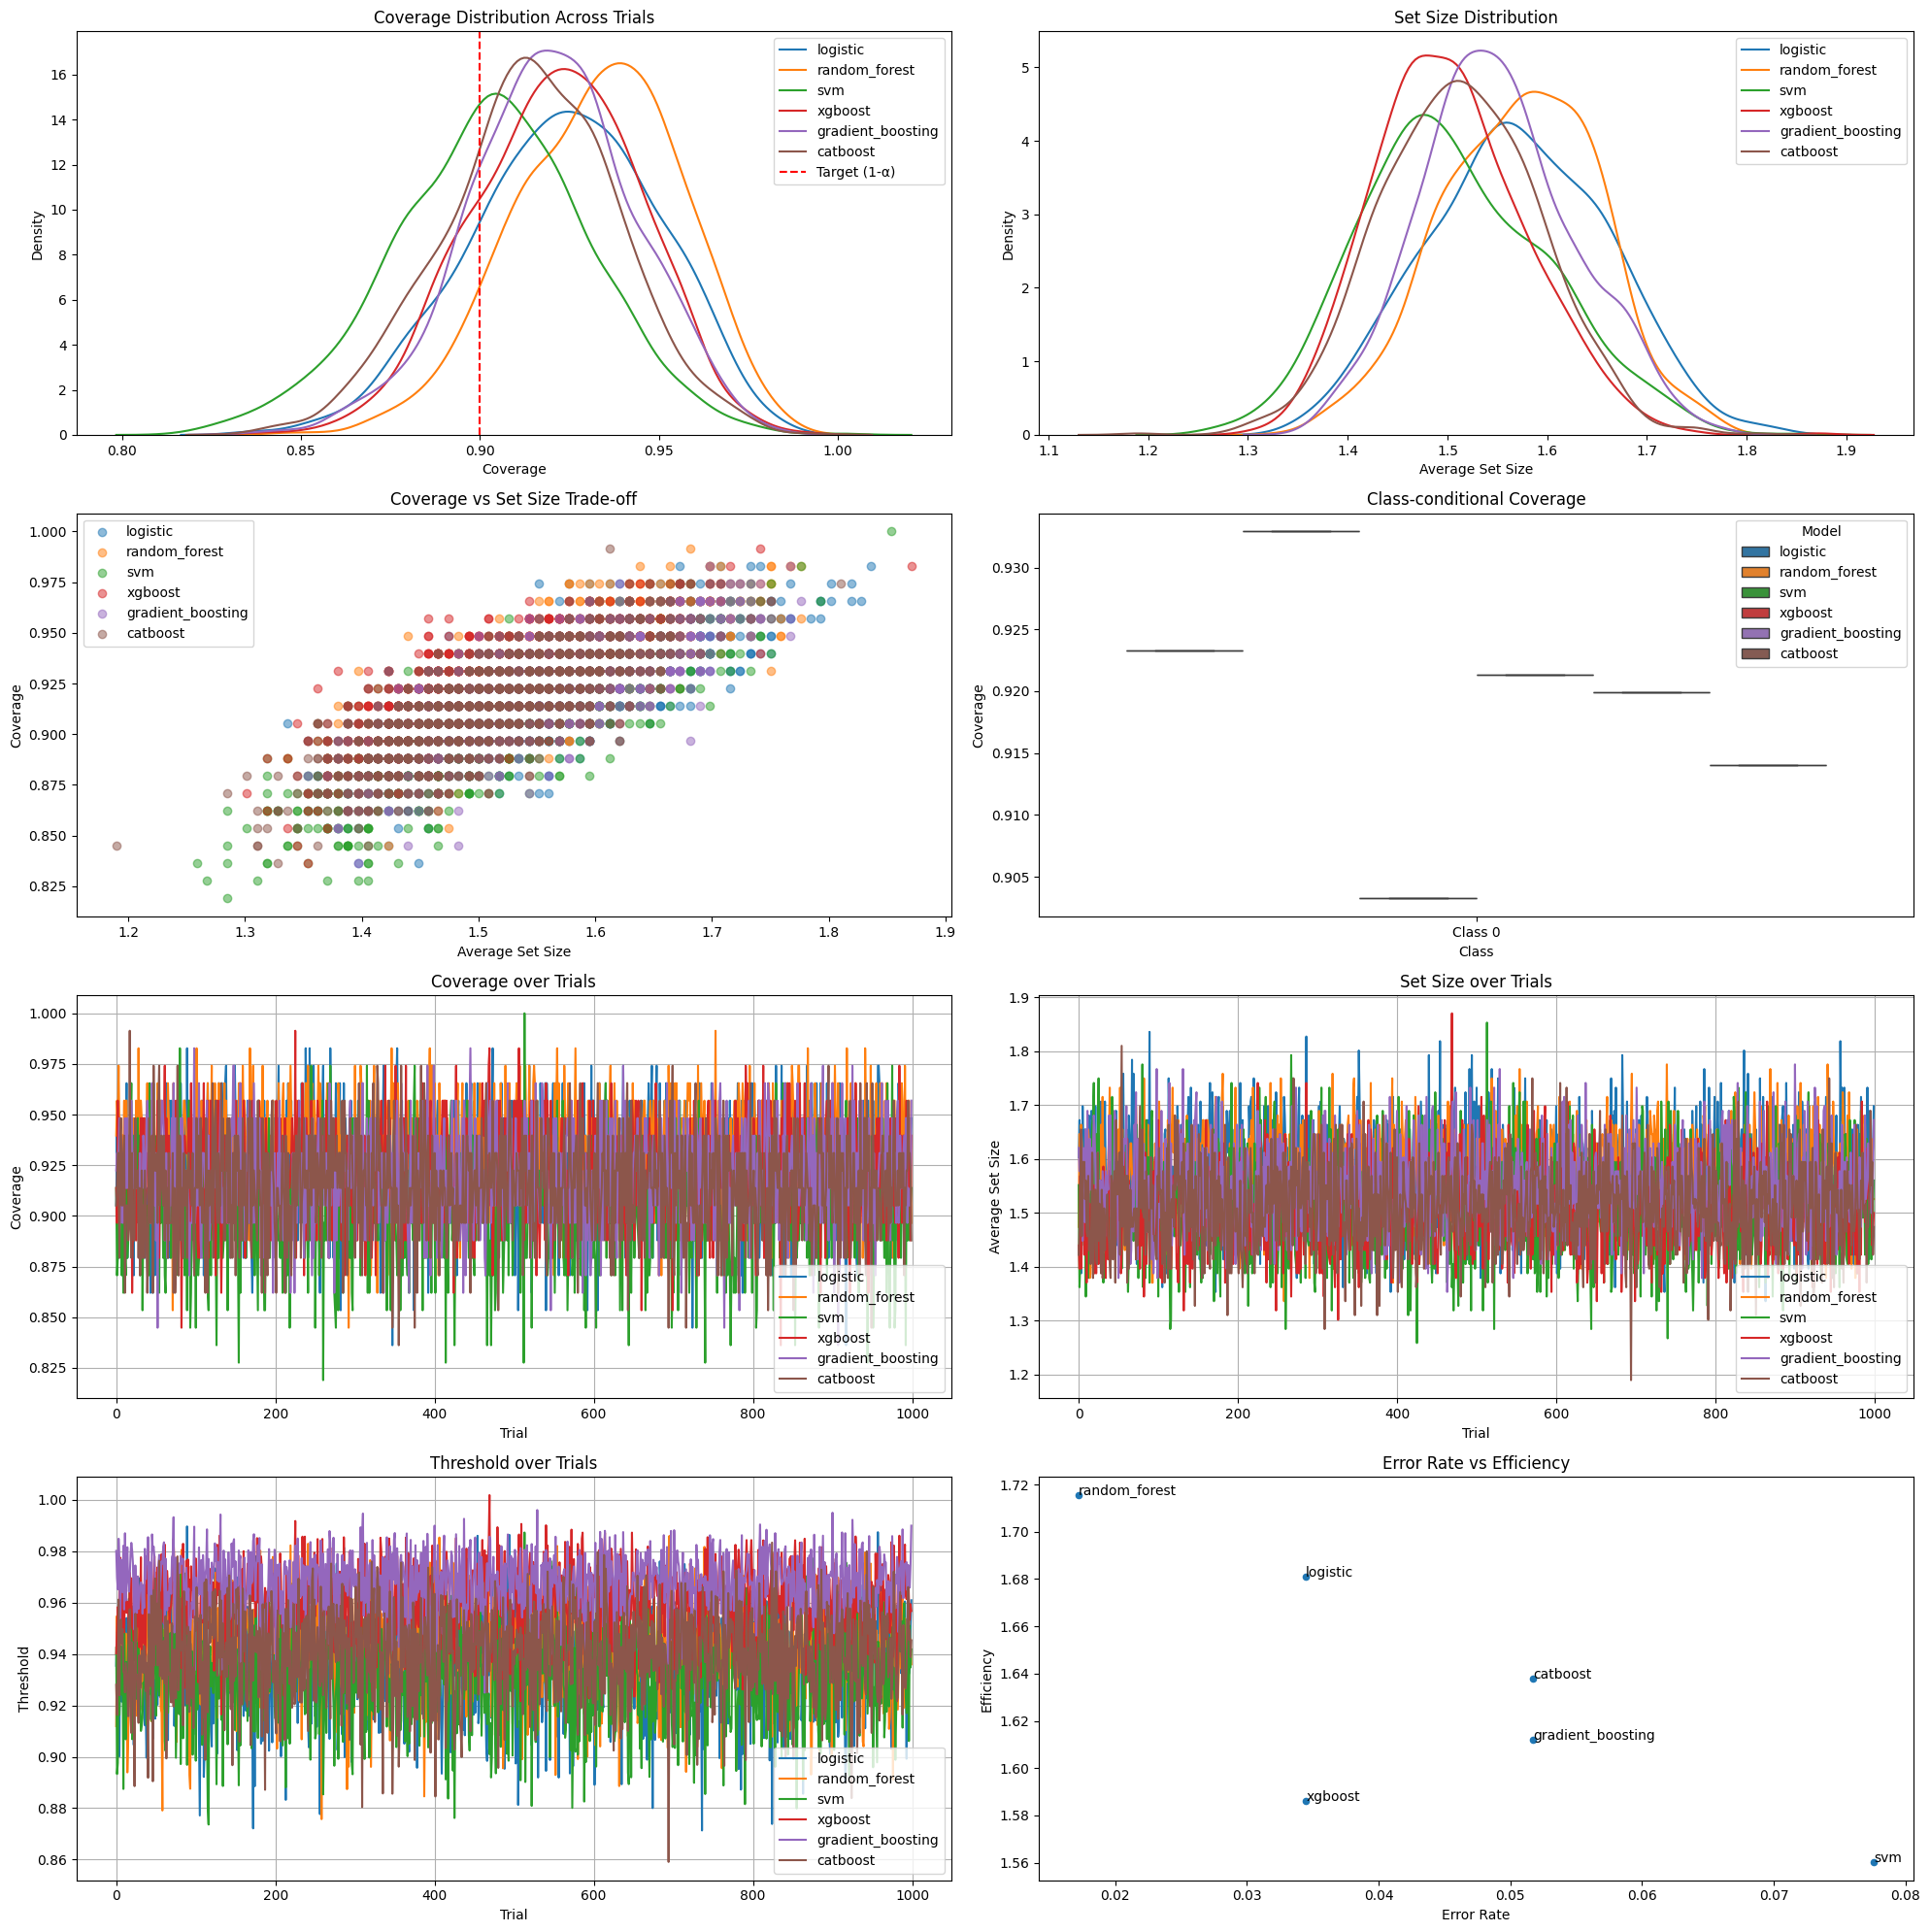

In [22]:
# Cell 5: Generate Visualization
def create_visualization():
    try:
        fig = analyzer.plot_comprehensive_analysis(all_results, y_test)
        plt.show()
    except Exception as e:
        print(f"Error creating visualization: {str(e)}")

create_visualization()

In [23]:
# Cell 6: Process Sample Patients
def analyze_sample_patients():
    print("\nAnalyzing sample patients...")
    try:
        analyzer.process_patients_multi_model(df, num_samples=5)
    except Exception as e:
        print(f"Error processing sample patients: {str(e)}")

analyze_sample_patients()


Analyzing sample patients...

Patient Analysis Results:

Patient ID: 668
--------------------------------------------------
Basic Information:
• Age: 43
• BMI: 34.0
• Glucose: 98

Risk Factors:
• High BMI (34.0)
• Low Blood Pressure (58 mm Hg)
• Multiple Pregnancies (6)
• High Insulin Level (190 μU/ml)

Actual Outcome: Non-diabetic

Model Predictions:
------------------------------

Logistic Model:
• Prediction: Non-Diabetic
• Confidence: 70.9%
• Assessment: Uncertain

Random_Forest Model:
• Prediction: Non-Diabetic, Diabetic
• Confidence: 54.9%
• Assessment: Highly Uncertain

Svm Model:
• Prediction: Non-Diabetic
• Confidence: 71.5%
• Assessment: Uncertain

Xgboost Model:
• Prediction: Diabetic, Non-Diabetic
• Confidence: 53.9%
• Assessment: Highly Uncertain

Gradient_Boosting Model:
• Prediction: Diabetic, Non-Diabetic
• Confidence: 60.3%
• Assessment: Highly Uncertain

Catboost Model:
• Prediction: Non-Diabetic, Diabetic
• Confidence: 51.6%
• Assessment: Highly Uncertain

Ensemble 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid featur


Logistic Model:
• Prediction: Non-Diabetic
• Confidence: 86.1%
• Assessment: Uncertain

Random_Forest Model:
• Prediction: Non-Diabetic
• Confidence: 90.1%
• Assessment: Definitive

Svm Model:
• Prediction: Non-Diabetic
• Confidence: 87.7%
• Assessment: Uncertain

Xgboost Model:
• Prediction: Non-Diabetic
• Confidence: 89.0%
• Assessment: Uncertain

Gradient_Boosting Model:
• Prediction: Non-Diabetic
• Confidence: 89.1%
• Assessment: Uncertain

Catboost Model:
• Prediction: Non-Diabetic
• Confidence: 83.8%
• Assessment: Uncertain

Ensemble Model:
• Prediction: Non-diabetic
• Confidence: 92.0%
• Assessment: Definitive prediction with high confidence


Patient ID: 690
--------------------------------------------------
Basic Information:
• Age: 34
• BMI: 24.6
• Glucose: 107

Risk Factors:
• Significant Family History (0.86)
• Multiple Pregnancies (8)

Actual Outcome: Non-diabetic

Model Predictions:
------------------------------

Logistic Model:
• Prediction: Non-Diabetic
• Confidence: 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, bu


Random_Forest Model:
• Prediction: Non-Diabetic, Diabetic
• Confidence: 54.5%
• Assessment: Highly Uncertain

Svm Model:
• Prediction: Non-Diabetic, Diabetic
• Confidence: 51.4%
• Assessment: Highly Uncertain

Xgboost Model:
• Prediction: Non-Diabetic, Diabetic
• Confidence: 60.0%
• Assessment: Highly Uncertain

Gradient_Boosting Model:
• Prediction: Non-Diabetic, Diabetic
• Confidence: 61.7%
• Assessment: Highly Uncertain

Catboost Model:
• Prediction: Diabetic, Non-Diabetic
• Confidence: 50.6%
• Assessment: Highly Uncertain

Ensemble Model:
• Prediction: Non-diabetic
• Confidence: 69.0%
• Assessment: Highly uncertain prediction with low confidence


Interpretation Guide

Assessment Levels:
• Definitive: Very high confidence (≥90%)
• Uncertain: Moderate confidence (70-89%)
• Highly Uncertain: Low confidence (<70%)

Risk Factors:
• High Glucose: >140 mg/dL
• High BMI: >30
• Age Risk: >50 years
• Family History: Diabetes pedigree >0.8

Confidence Interpretation:
• Higher confidence ind

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [24]:
# Cell 7: Calculate Feature Importance
def analyze_feature_importance():
    try:
        feature_importance = {}
        for model_name, model in analyzer.models.items():
            if hasattr(model.base_model, 'feature_importances_'):
                importance = model.base_model.feature_importances_
            elif hasattr(model.base_model, 'coef_'):
                importance = np.abs(model.base_model.coef_[0])
            else:
                continue

            feature_importance[model_name] = dict(zip(analyzer.feature_names, importance))

        print("\nFeature Importance Analysis:")
        for model_name, importances in feature_importance.items():
            print(f"\n{model_name} Top Features:")
            sorted_features = dict(sorted(importances.items(), key=lambda x: x[1], reverse=True))
            for feature, importance in list(sorted_features.items())[:5]:
                print(f"- {feature}: {importance:.3f}")

        return feature_importance
    except Exception as e:
        print(f"Error calculating feature importance: {str(e)}")
        return None

feature_importance = analyze_feature_importance()


Feature Importance Analysis:

logistic Top Features:
- Glucose: 0.964
- BMI: 0.687
- Age: 0.373
- Pregnancies: 0.181
- DiabetesPedigreeFunction: 0.139

random_forest Top Features:
- Glucose: 0.282
- BMI: 0.163
- Age: 0.147
- DiabetesPedigreeFunction: 0.108
- BloodPressure: 0.082

xgboost Top Features:
- Glucose: 0.296
- BMI: 0.152
- Age: 0.131
- Pregnancies: 0.122
- Insulin: 0.097

gradient_boosting Top Features:
- Glucose: 0.441
- BMI: 0.185
- Age: 0.149
- DiabetesPedigreeFunction: 0.094
- Insulin: 0.047

catboost Top Features:
- Glucose: 28.422
- BMI: 16.907
- Age: 16.474
- DiabetesPedigreeFunction: 10.732
- Insulin: 7.902
